<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

# Assignment 1 - CNN's and VGG16

*In this assingment, you will further familiraize yourself with CNN's and how to implement them. For this particular example, we will ask you to implement the layer structure of VGG16, an old but fairly effective and simple CNN structure.*

*Keep in mind, that while VGG16 and other CNN's you have implemented so far, only incoporate convolutions and pooling layers, many state-of-the-art models  use a variety of other techniques, such as skip connections, or self-attention to get better results.*

*As you write code for this assignment, try to keep in mind to write good code. That might sound vague, but just imagine that some other poor sod will have to read your code at some point, and easily readable, understandable code, will go a long way to making their life easier. However, this is not a coding course, so the main focus should of course be on the exercises themselves.*

**Keep in mind, this assignment does not count towards your final grade in the course. When any of the exercises mention 'grading', it refers to commenting and correcting answers, not necessarily giving you a score which will reflect in your grade, so dw :)**


**Hand-in date is 30/09 at the latest if you want to recieve feedback!!**

</span>

## Boilerplate start - you can mostly ignore this!

In [1]:
import os
import torch
import PIL
from torch import nn
from torch.utils.data.dataloader import default_collate

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torchvision.models

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import utils

# Check if you have cuda available, and use if you do
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Set a random seed for everything important
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = False

# Set a seed with a random integer, in this case, I choose my verymost favourite sequence of numbers
seed_everything(sum([115, 107, 105, 98, 105, 100, 105, 32, 116, 111, 105, 108, 101, 116]))

cuda


In [2]:
# Specify dataset you wanna use
def get_dataset(dataset_name, validation_size=0.1, transform=None, v=True, imagenette_resize_size=256, imagenette_crop_size=224):

    if transform is None:
        transform = ToTensor()

    if dataset_name == 'cifar10':
        train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
        test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=ToTensor())

        # Purely for our convenience - Mapping from cifar labels to human readable classes
        cifar10_classes = {
            0: 'airplane',
            1: 'automobile',
            2: 'bird',
            3: 'cat',
            4: 'deer',
            5: 'dog',
            6: 'frog',
            7: 'horse',
            8: 'ship',
            9: 'truck'
        }

    elif dataset_name == 'mnist':
        train_set = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
        test_set = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

    elif dataset_name == 'imagenette':
        download = not os.path.exists('./data/imagenette2')

        # Specific transform in the case we use imagenette
        imagenette_transform = transforms.Compose([
            transforms.Resize(imagenette_resize_size),        # Resize the image to a default value of 256x256 (what the VGG paper does)
            transforms.RandomCrop(imagenette_crop_size),        # Crop the center to a default value of 224x224 (what the VGG paper does)
            transforms.ToTensor(),         # Convert to tensor
            transforms.Normalize(mean=[0.4650, 0.4553, 0.4258], std=[0.2439, 0.2375, 0.2457]) # Normalize each image, numbers because of function courtesy of chatgpt
        ])
        train_set = datasets.Imagenette(root='./data', split='train', download=download, size='full', transform=imagenette_transform)
        test_set = datasets.Imagenette(root='./data', split='val', download=False, size='full', transform=imagenette_transform)
    
    # If we want a validation set of a given size, take it from train set
    if validation_size is not None:
        # These will both be of the torch.utils.data.Subset type (not the Dataset type), and are basically just mappings of indices
        # This does not matter when we make Dataloaders of them, however
        if dataset_name != 'imagenette':
            train_set, validation_set = torch.utils.data.random_split(train_set, [1-validation_size, validation_size])

        # In the case of imagenette, the 'test set' is already a pretty big validation set, so we'll use that to create the test set instead
        else:
            validation_set, test_set = torch.utils.data.random_split(test_set, [validation_size, 1-validation_size])

    if v:
        print(f"There are {len(train_set)} examples in the training set")
        print(f"There are {len(test_set)} examples in the test set \n")

        print(f"Image shape is: {train_set[0][0].shape}, label example is {train_set[0][1]}")

    return train_set, validation_set, test_set

# collate function just to cast to device, same as in week_3 exercises
def collate_fn(batch):
    return tuple(x_.to(device) for x_ in default_collate(batch))

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Task 1 - Theoretical questions

These questions are meant to test your general knowledge of CNN's, feel free to contact or write the TA's if you have any questions about any of them


#### **1.1. What is the reason we add MaxPooling or AveragePooling in CNN's?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

So, pooling reduces spatial size of feature maps, by down samlpling. This in turn lowers the number of parameters and computations in layers, increasing the speed and memory utilization of the NN. Pooling also increases the invariance of the model, making it less succebtible to other transformations in the input. pooling can also help with noise reduction by emphasizing important features while discarding small variations/noise. It helps generalize the model, and makes it not focus on small pixels, but the overall input. 

</span>

#### **1.2. In the [VGG paper](https://arxiv.org/pdf/1409.1556), last paragraph of 'training', page 4, they mention images being randomly cropped after being rescaled. Why do you think they crop images only *after* rescaling them?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Well, the first thing in mind is to retain as much possible potentially important information before cropping. There is also the required input size for the network(224x224). If we did the crop first, there's a risc of distorting the image when rescaling the input. 
There is also something about $S$ in it's effect on the image size (shorter side of image = $S$). EX: image size = 800x600
S = 256 -> 256/600 0.43 -> new image size = 344((800*0.43))x256. it is the cropped part of the image. exlpain further

</span>

#### **1.3. After this, they mention "further augmenting the dataset" by random horizontal flipping and random RGB color shift. Why do you think they do this?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Objects don't have a designated right or left, up or down direction, so to ensure there is no bias in the direction of the data, the random horizontal flipping helps the model train on varied directional inputs, making it more robust in that regard. It makes the model focus on what an object is, not where it's pointed. In the same manner, different shifts in RGB can help the model recognize different objects in different lighting scenarios, as that also varies greatly in reality (Lighting, shadows, camerafilters, hues etc) so hopefully this makes the model more colour invariant.
These two methods makes the model rely more on shapes, textures and edges

</span>

#### **1.4. Why do you think they do not randomly translate images? (Translate being to move images left, right, up, down)**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

They do not use translations because they already use cropping with the setup of convolution and pooling. This essentially does the same thing, but in a more effective way, with the random cropping. This means it becomes redundant to also use translations.

</span>

#### **1.5. Which of the following classification tasks do you think is more difficult for a machine learning model, and why?**

- **Telling German Shepherds (Schæferhunde) from Labradors**
- **Telling dogs from cats**
- **Telling horses from cars from totem poles from chainsaws**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

1. differentiation between dog breeds is propably the most difficult task, since there are so many similarities between these breeds, so the model must learn to differentiate the small details i.e it being more difficult

2. Dogs and cats are somewhat similar in structure, but the overall differences should be more than noticiable to the system, making it somewhat easier than differentiating dog breeds, but still on the difficult side

3. Differences between horses(four legged animals) and cars(inanimate vehicle) should be great, making the model able to rely more on less detailed features. Totem poles and chainsaws are also very different in structure, so the same applies.

</span>

#### **1.6. In real life, you often find that neural networks aren't used "for everything", older and often more simple models like random forest and linear regression still dominate a lot of fields. Reason a bit about why this is the case**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Propably because some simple models are way more efficent in terms of computing cost, and because they simply mimic real life tendencies that are abundant. So it doesnt always justify the cost of using a NN, when a simple model does it faster and cheaper. 
Cases for NN's are where there is an abundance of high dimensional data with lots of features to weigh, usually more complicated tasks where a simple model doesn't cut it. 

*utputs from simple models are also easily understood/interpreted, whereas explaining the architecture and function of a NN and how it produces the output can be difficult* maybe cut

There is also something to discuss in terms of sheer size of datasets for models. NN's usually require vast amounts of data, where general simple models can usually cut it with less(still, more is better, if you disregard cost)

</span>


#### **1.7. The VGG16-D conv layers all use the same kernel size. Come up with reasons for why you would use bigger/smaller kernel sizes**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Smaller kernels focus on the small details in local patterns, possibly finding more non linearities.
Larger kernels conversely find larger patterns and add more weights pr input channel. a 7x7 kernel adds 49 weights, while three 3x3 kernels only add 27 weights. Smaller kernels mean less parameters, which makes the model less prone to overfitting. also computationally cheaper, since there is less work pr pixel analyzed. Smaller kernels allow for more activation functions between layers.



</span>

</span>


<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

## Boilerplate end - Your implementation work begins here:

Below, you are given a working example of a CNN, not much different from the one in the exercises of week 3. Your job is to complete the implementation questions below.

You do not need to do all the exercises below, or even do them in order, we will obviously only grade the ones you have done, however. Please just check off completed exercises as shown below, so we will know what to look for when grading your assignment. You can add as much text below each question as you want to either argue for your choice of implementation, discuss your results, or ask us questions, we will consider this when grading the assignment.

Many tasks include a <input type="checkbox"> checkbox. These are for you to check when you have written code to help solve an exercise. This is to indicate to the TA's which tasks to look for code to correct. Remember to check these if you want feedback on your code.

For your convenience, we reccommend implementing two models: One bigger for the VGG16-D exercises, meant to be used only with images from the Imagenette dataset, and one smaller, which can also take the other datasets. The model already implemented below should fill the role of the latter.

Finally, if you're not able to train the VGG16-D model because it is too big, you can also load the weights of the model using the funciton implemented for exactly that. We do, however, reccommend training it from scratch yourself, if possible.

You can toggle the weight imports using the boolean `USE_PRETRAINED_WEIGHTS`. This results in a small reduction in iteration time - the real time save is that it now requires significantly fewer epochs to reach a decent accuracy. (The iteration time is roughly the same since the forward pass through the model must be computed in the same manner.)

**DISCLAIMER: The weight imports will fail if your VGG16 model does not correctly correspond to the correct model architecture.**

---

To reiterate: The code in the cells below should already work to train a model for the MNIST dataset. **This is not the VGG16-D model, however!** To implement VGG16-D, you are suposed to copy or replace this already existing model with your own implementation.

</span>

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### 💻 Task 2 - Implementation

Assume all tasks below here have the 💻 tag - they all require some degree of implementation work. 

Many tasks include a <input type="checkbox"> checkbox. These are for you to check when you have written code to help solve an exercise. This is to indicate to the TA's which tasks to look for code to correct. Remember to check these if you want feedback on your code.

Remember, green boxes are for providing explanations. They are not mandatory to fill out, but if you want feedback for your reasoning, write in them.

**HINT: If it is taking waaaaay to long to train with imagenette, you can go around what they do in the paper (resizing to 256 and thereafter, cropping to 224), by reducing either of these to other values. Much of the training time when using imagenette can reasonably be attributed to simply having high-resolution images. (Do note that reducing resolution is likely to reduce model performance as well)**

#### **2.1. Implement the layer structure of VGG16-D by following either this [Medium article](https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918) (fairly easy), or the [official paper](https://arxiv.org/pdf/1409.1556) (slightly harder)**


**Note: The original VGG16-D layer structure is meant to be used with $224 \times 224$ sized images, only the  imagenette dataset in this notebook has this, not the MNIST**

#### **2.2. Overfitting Analysis**
- <input type="checkbox"> **Can you make the VGG16-D model overfit to the imagenette dataset? If not, what about another dataset?**


<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Overfitting is when our model has learned too well from the training data, and thus performs very well on training data, but poorly on testing data. The model has focused too much on the noise present in the data, and thus cannot correctly classify the test data. Underfitting would be the model learning too little, and thus performing poorly on both training and test data.

so if we use very little training data, the model should be very good at recognizing those patterns, but will fail more often when testing on new data. Alternatively we could remove some of our regularization methods. If we remove dropout(i.e the random turnoff of neutrons, which hinders the model in learning exact patterns.) the model is more prone to retain exact patterns from the training data. 

If we remove weight decay(i.e the model lowering values of large weights, leading to less memorization) the model emphasizes more on the learned weights from training, making it less flexible for new data. If we remove the random cropping and colour shifting the models is also less resistant to learning the underlying patterns in edges and shapes, making it decent at training and bad at testing. 

if we increase the amount of parameters, there is more information to retain from the training and it gets more rooted in the training set. paired with a small training data set makes the model more fixed in the training patterns.



</span>

- <input type="checkbox"> **Can you change the amount of dropout to increase or decrease the rate of overfitting?**



<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

if we decrease dropout, it should should increase the risk of the model being rooted in training data(memorizing it), and then failing on new testing data. If we increase dropout too much we don't allow the model to retain any useful patterns, which makes the model underfit.
from the paper they use a dropoutrate of 0.5(half the neurons are deactivated randomly)  


</span>

- <input type="checkbox"> **Can you make the smaller model overfit to any of its datasets? Is it harder or easier? Explain your answer**


<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">


If we just use default settings for the smaller model it overfits. If we check the architecture of the smaller model we can see that the models lacks regularizations. there is no dropout, no regularization of the data. the model does use weight decay(adam), and there is also way less convolutional layers and pooling layers. the model is simpler, and more suitable for prototyping simpler tasks, rather than image analaysis


</span>

#### **2.3. Hyperparameter Optimization**
- <input type="checkbox"> Try to improve the test accuracy of either of your models by changing some of they hyperparameters. To make it easier, try to keep detailed results of your experimental setups and your preliminary results. Argue for your changes. Examples of possible changes are shown below:
- <input type="checkbox"> Add more/fewer kernels
- <input type="checkbox"> Add more/less dropout
- <input type="checkbox"> Add [BatchNorm](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)
- <input type="checkbox"> Change the intial transform when loading the data to make larger/smaller images

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

For the Simple model, making each convolutional layer have consistent padding(default for conv2d is padding=0). whithoud padding we turn the output size smaller, and then we lose details. And if we add more conv layers, we increase the amount of information we can get from the inputs. it goes: lower layers: edges and simple textures, middle layers: shapes and parts of objects, deep layers: learning objects as a whole. the more layers we add of convolution the more the network learns spatial patterns. Then if we add some dropout layers we excpect the model to be more resilient to being stuck in the patterns of the training data, and more succeptible to learn the overall trends. 
we see from the plot that we have made the model less prone to overfitting, though there is only a slight difference in actual performance. For that we could further augment the model architecture, and augment the data more before we put it through the network.

</span>


#### **2.4. Performance Optimization**
- <input type="checkbox"> Change the model (or any other code in the whole script) to make either training, inference, or both, as quick as possible, while still keeping a reasonable test accuracy. Explain what you did to achieve this.

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

#changes from simpleVGG: removed layers from the fully connected part, and added a batchnorm layer after each conv layer. Also added adaptive avg pooling to reduce feature map size before flattening.
this should reduce parameters(lower computation time) and increase speed of convergence.
Batchnorm was added after convolutions to spped up training and stabilizing gradients, so we hopefully need less epochs.
used less channels deeper layers(256 -> 128) to reduce parameters and computation time.
AMP is used for faster training with less memory usage.

average runtime for 1 epoch is 40 seconds on the cifar10 set. Insert other models avrg time here*

</span>


#### **2.5. Error Analysis**
- <input type="checkbox"> During evaluation, extract some images which were not correctly classified, plot these images and reason about what made them hard-to-classify


<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

$\dots$

</span>

</span>

In [3]:
class OG(torch.nn.Module):
    def __init__(self, num_classes, in_channels=1, features_fore_linear=25088, dataset=None):
        super().__init__()
        
        # Helper hyperparameters to keep track of VGG16 architecture
        conv_stride = ...
        pool_stride = ...
        conv_kernel = ...
        pool_kernel = ...
        dropout_probs = ...
        optim_momentum = ...
        weight_decay = ...
        learning_rate = ...

        # Define features and classifier each individually, this is how the VGG16-D model is orignally defined
        self.features = torch.nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1), # dim = in
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
        ).to(device)
        
        self.classifier = torch.nn.Sequential(
            nn.Linear(in_features=features_fore_linear, out_features=600),
            nn.ReLU(),
            nn.Linear(in_features=600, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=num_classes)
        ).to(device)
        
        # In the paper, they mention updating towards the 'multinomial logistic regression objective'
        # As can be read in Bishop p. 159, taking the logarithm of this equates to the cross-entropy loss function.
        self.criterion = nn.CrossEntropyLoss()

        # Optimizer - For now just set to Adam to test the implementation
        self.optim = torch.optim.Adam(list(self.features.parameters()) + list(self.classifier.parameters()), lr=0.001)
        # self.optim = torch.optim.SGD(list(self.features.parameters()) + list(self.classifier.parameters()), lr=learning_rate, momentum=optim_momentum, weight_decay=weight_decay)

        self.dataset = dataset

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

    def train_model(self, train_dataloader, epochs=1, val_dataloader=None):
        
        # Call .train() on self to turn on dropout
        self.train()

        # To hold accuracy during training and testing
        train_accs = []
        test_accs = []

        for epoch in range(epochs):
            
            epoch_acc = 0

            for inputs, targets in tqdm(train_dataloader):
                logits = self(inputs)
                loss = self.criterion(logits, targets)
                loss.backward()

                self.optim.step()
                self.optim.zero_grad()

                # Keep track of training accuracy
                epoch_acc += (torch.argmax(logits, dim=1) == targets).sum().item()
            train_accs.append(epoch_acc / len(train_dataloader.dataset))

            # If val_dataloader, evaluate after each epoch
            if val_dataloader is not None:
                # Turn off dropout for testing
                self.eval()
                acc = self.eval_model(val_dataloader)
                test_accs.append(acc)
                print(f"Epoch {epoch} validation accuracy: {acc}")
                # turn on dropout after being done
                self.train()
        
        return train_accs, test_accs

    def eval_model(self, test_dataloader):
        
        self.eval()
        total_acc = 0

        for input_batch, label_batch in test_dataloader:
            logits = self(input_batch)

            total_acc += (torch.argmax(logits, dim=1) == label_batch).sum().item()

        total_acc = total_acc / len(test_dataloader.dataset)

        return total_acc

    def predict(self, img_path):
        img = PIL.Image.open(img_path)
        img = self.dataset.dataset.transform(img)
        classification = torch.argmax(self(img.unsqueeze(dim=0)), dim=1)
        return img, classification
    
    def predict_random(self, num_predictions=16):
        """
        Plot random images from own given dataset
        """
        random_indices = np.random.choice(len(self.dataset)-1, num_predictions, replace=False)
        classifcations = []
        labels = []
        images = []
        for idx in random_indices:
            img, label = self.dataset.__getitem__(idx)

            classifcation = torch.argmax(self(img.unsqueeze(dim=0)), dim=1)

            classifcations.append(classifcation)
            labels.append(label)
            images.append(img)

        return classifcations, labels, images




In [4]:
class simpleVGG(torch.nn.Module):
    def __init__(self, num_classes, in_channels=1, features_fore_linear=25088, dataset=None):
        super().__init__()
        
        # Helper hyperparameters to keep track of VGG16 architecture
        conv_stride = 1
        pool_stride = 2
        conv_kernel = (3,3)
        pool_kernel = (2,2)
        dropout_probs = 0.3
        optim_momentum = 0.9
        weight_decay = 5*10**(-4)
        learning_rate = 10**(-2)

        # Define features and classifier each individually, this is how the VGG16-D model is orignally defined
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Flatten()).to(device)
        
        self.classifier = nn.Sequential(
            nn.Linear(features_fore_linear, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)).to(device)

        # In the paper, they mention updating towards the 'multinomial logistic regression objective'
        # As can be read in Bishop p. 159, taking the logarithm of this equates to the cross-entropy loss function.
        self.criterion = nn.CrossEntropyLoss()

        # Optimizer - For now just set to Adam to test the implementation
        self.optim = torch.optim.Adam(
        self.parameters(),
        lr=1e-3,
        weight_decay=1e-4)
        # self.optim = torch.optim.SGD(list(self.features.parameters()) + list(self.classifier.parameters()), lr=learning_rate, momentum=optim_momentum, weight_decay=weight_decay)

        self.dataset = dataset

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

    def train_model(self, train_dataloader, epochs=1, val_dataloader=None):
        
        # Call .train() on self to turn on dropout
        self.train()

        # To hold accuracy during training and testing
        train_accs = []
        test_accs = []

        for epoch in range(epochs):
            
            epoch_acc = 0

            for inputs, targets in tqdm(train_dataloader):
                logits = self(inputs)
                loss = self.criterion(logits, targets)
                loss.backward()

                self.optim.step()
                self.optim.zero_grad()

                # Keep track of training accuracy
                epoch_acc += (torch.argmax(logits, dim=1) == targets).sum().item()
            train_accs.append(epoch_acc / len(train_dataloader.dataset))

            # If val_dataloader, evaluate after each epoch
            if val_dataloader is not None:
                # Turn off dropout for testing
                self.eval()
                acc = self.eval_model(val_dataloader)
                test_accs.append(acc)
                print(f"Epoch {epoch} validation accuracy: {acc}")
                # turn on dropout after being done
                self.train()
        
        return train_accs, test_accs

    def eval_model(self, test_dataloader):
        
        self.eval()
        total_acc = 0

        for input_batch, label_batch in test_dataloader:
            logits = self(input_batch)

            total_acc += (torch.argmax(logits, dim=1) == label_batch).sum().item()

        total_acc = total_acc / len(test_dataloader.dataset)

        return total_acc

    def predict(self, img_path):
        img = PIL.Image.open(img_path)
        img = self.dataset.dataset.transform(img)
        classification = torch.argmax(self(img.unsqueeze(dim=0)), dim=1)
        return img, classification
    
    def predict_random(self, num_predictions=16):
        """
        Plot random images from own given dataset
        """
        random_indices = np.random.choice(len(self.dataset)-1, num_predictions, replace=False)
        classifcations = []
        labels = []
        images = []
        for idx in random_indices:
            img, label = self.dataset.__getitem__(idx)

            classifcation = torch.argmax(self(img.unsqueeze(dim=0)), dim=1)

            classifcations.append(classifcation)
            labels.append(label)
            images.append(img)

        return classifcations, labels, images


In [13]:
from torch.cuda import amp
def conv_block(in_channels, out_channels, k=3, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=k, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True))

class fastsimpleVGG(torch.nn.Module):                                  #512x7x7
    def __init__(self, num_classes, in_channels=1, features_fore_linear=25088, dataset=None): #(self,num_classes, in_channels=1, base_channels=32, dataset = None):
        super().__init__()
        base_channels = 32

        self.features = nn.Sequential(
            conv_block(in_channels, base_channels), 
            conv_block(base_channels, base_channels),
            nn.MaxPool2d(2, 2),                     


            conv_block(base_channels, base_channels*2), 
            conv_block(base_channels*2, base_channels*2),
            nn.MaxPool2d(2, 2),                         


            conv_block(base_channels*2, base_channels*4), 
            nn.AdaptiveAvgPool2d((1,1)), # adaptiveavg pool 
            nn.Flatten()
        ).to(device)


        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features=128, out_features=600),  
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(in_features=600, out_features=num_classes)
        ).to(device)

        self.criterion = nn.CrossEntropyLoss()

        #self.optim = torch.optim.Adam(self.features.parameters()) + list(self.classifier.parameters()), lr=1e-3, weight_decay=1e-4))
        
        self.optim = torch.optim.Adam(list(self.features.parameters()) + list(self.classifier.parameters()), lr=0.001, weight_decay=1e-4)

        self.dataset = dataset

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)
    
    def train_model(self, train_dataloader, epochs=10, val_dataloader=None, device='cuda'):
        self.train()

        self.to(device)
        scaler = amp.GradScaler()
        scheduler = torch.optim.lr_scheduler.StepLR(self.optim, step_size=8, gamma=0.1)
        train_accs, test_accs = [], []

        # speed trick
        torch.backends.cudnn.benchmark = True

        for epoch in range(epochs):
            self.train()
            running_correct = 0
            total = 0
            pbar = tqdm(train_dataloader, desc=f"Epoch {epoch}")
            for inputs, targets in pbar:
                inputs = inputs.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)

                with amp.autocast():
                    logits = self(inputs)
                    loss = self.criterion(logits, targets)

                self.optim.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(self.optim)
                scaler.update()

                preds = logits.argmax(dim=1)
                running_correct += (preds == targets).sum().item()
                total += targets.size(0)
                pbar.set_postfix(loss=loss.item(), acc=running_correct/total)

            train_accs.append(running_correct / len(train_dataloader.dataset))

            if val_dataloader is not None:
                self.eval()
                test_acc = self.eval_model(val_dataloader, device=device)
                test_accs.append(test_acc)
                print(f"  Test acc: {test_acc:.4f}")

            scheduler.step()

        return train_accs, test_accs
    
    def eval_model(self, test_dataloader, device='cuda'):
        self.to(device)
        self.eval()
        correct = 0
        total = 0
        # inference_mode is slightly faster than no_grad on recent PyTorch
        with torch.inference_mode():
            for inputs, targets in test_dataloader:
                inputs = inputs.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)
                with amp.autocast():
                    logits = self(inputs)
                preds = logits.argmax(dim=1)
                correct += (preds == targets).sum().item()
                total += targets.size(0)
        return correct / total

#changes from simpleVGG: removed layers from the fully connected part, and added a batchnorm layer after each conv layer. Also added adaptive avg pooling to reduce feature map size before flattening.
# this should reduce parameters(lower computation time) and increase speed of convergence.
# Batchnorm was added after convolutions to spped up training and stabilizing gradients, so we hopefully need less epochs.
# used less channels deeper layers(256 -> 128) to reduce parameters and computation time.
# AMP is used for faster training with less memory usage.

In [5]:
class VGG16(torch.nn.Module):
    def __init__(self, num_classes, in_channels=3, features_fore_linear=512*7*7, dataset=None):
        super().__init__()
        
        # Helper hyperparameters to keep track of VGG16 architecture
        conv_stride = 1
        pool_stride = 2
        conv_kernel = (3,3)
        pool_kernel = (2,2)
        dropout_probs = 0.5
        optim_momentum = 0.9
        weight_decay = 5*10**(-4)
        learning_rate = 10**(-2)

        # Define features and classifier each individually, this is how the VGG16-D model is originally defined
        self.features = torch.nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=conv_kernel, padding=1, stride=conv_stride), nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=conv_kernel, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=conv_kernel, padding=1, stride=conv_stride), nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=conv_kernel, padding=1, stride=conv_stride), nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=conv_kernel, padding=1, stride=conv_stride), nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=conv_kernel, padding=1, stride=conv_stride), nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=conv_kernel, padding=1, stride=conv_stride), nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=conv_kernel, padding=1, stride=conv_stride), nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, padding=1, stride=conv_stride), nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, padding=1, stride=conv_stride), nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, padding=1, stride=conv_stride), nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, padding=1, stride=conv_stride), nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=conv_kernel, padding=1, stride=conv_stride), nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride),
            nn.Flatten(),
        ).to(device)
        
        self.classifier = torch.nn.Sequential(
            nn.Linear(in_features=features_fore_linear, out_features=4096), nn.ReLU(True), nn.Dropout(dropout_probs),
            nn.Linear(in_features=4096, out_features=4096), nn.ReLU(True), nn.Dropout(dropout_probs),
            nn.Linear(in_features=4096, out_features=num_classes)
        ).to(device)
        
        # In the paper, they mention updating towards the 'multinomial logistic regression objective'
        # As can be read in Bishop p. 159, taking the logarithm of this equates to the cross-entropy loss function.
        self.criterion = nn.CrossEntropyLoss()

        # Optimizer - For now just set to Adam to test the implementation
        self.optim = torch.optim.SGD(list(self.features.parameters()) + list(self.classifier.parameters()), lr=learning_rate, momentum=optim_momentum, weight_decay=weight_decay)

        self.dataset = dataset

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

    def train_model(self, train_dataloader, epochs=1, val_dataloader=None):
        
        # Call .train() on self to turn on dropout
        self.train()

        # To hold accuracy during training and testing
        train_accs = []
        test_accs = []

        for epoch in range(epochs):
            
            epoch_acc = 0

            for inputs, targets in tqdm(train_dataloader):
                logits = self(inputs)
                loss = self.criterion(logits, targets)
                loss.backward()

                self.optim.step()
                self.optim.zero_grad()

                # Keep track of training accuracy
                epoch_acc += (torch.argmax(logits, dim=1) == targets).sum().item()
            train_accs.append(epoch_acc / len(train_dataloader.dataset))

            # If val_dataloader, evaluate after each epoch
            if val_dataloader is not None:
                # Turn off dropout for testing
                self.eval()
                acc = self.eval_model(val_dataloader)
                test_accs.append(acc)
                print(f"Epoch {epoch} validation accuracy: {acc}")
                # turn on dropout after being done
                self.train()
        
        return train_accs, test_accs

    def eval_model(self, test_dataloader):
        
        self.eval()
        total_acc = 0

        for input_batch, label_batch in test_dataloader:
            logits = self(input_batch)

            total_acc += (torch.argmax(logits, dim=1) == label_batch).sum().item()

        total_acc = total_acc / len(test_dataloader.dataset)

        return total_acc

    def predict(self, img_path):
        img = PIL.Image.open(img_path)
        img = self.dataset.dataset.transform(img)
        classification = torch.argmax(self(img.unsqueeze(dim=0)), dim=1)
        return img, classification
    
    def predict_random(self, num_predictions=16):
        """
        Plot random images from own given dataset
        """
        random_indices = np.random.choice(len(self.dataset)-1, num_predictions, replace=False)
        classifications = []
        labels = []
        images = []
        for idx in random_indices:
            img, label = self.dataset.__getitem__(idx)

            classification = torch.argmax(self(img.unsqueeze(dim=0)), dim=1)

            classifications.append(classification)
            labels.append(label)
            images.append(img)

        return classifications, labels, images

def get_vgg_weights(model):
    """
    Loads VGG16-D weights for the classifier to an already existing model
    Also sets training to only the classifier
    """
    # Load the complete VGG16 model
    temp = torchvision.models.vgg16(weights='DEFAULT')

    # Get its state dict
    state_dict = temp.state_dict()

    # Change the last layer to fit our, smaller network
    state_dict['classifier.6.weight'] = torch.randn(10, 4096)
    state_dict['classifier.6.bias'] = torch.randn(10)

    # Apply the state dict and set the classifer (layer part) to be the only thing we train
    model.load_state_dict(state_dict)

    for param in model.features.parameters():
        param.requires_grad = False

    model.optim = torch.optim.Adam(model.classifier.parameters())


    return model


In [6]:
# Get data - switch to 'mnist' or 'cifar10' for a smaller (therefore faster to train), and possibly easier dataset
dataset_names = ["cifar10", "mnist", "imagenette"]
dataset_name = dataset_names[0]  #cifar10 mnist imagenette 0, 1, 2 mnist doesnt work, output size is too small 512x0x0
# Original imagenette resize sizes and crop sizes, these can be set lower if training is taking way too long.
imagenette_resize_size = 224
imagenette_crop_size = 200
train_set, validation_set, test_set = get_dataset(dataset_name, validation_size=0.1, imagenette_resize_size=imagenette_resize_size, imagenette_crop_size=imagenette_crop_size)

# Make dataloaders
batch_size=16
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
validation_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Files already downloaded and verified
Files already downloaded and verified
There are 45000 examples in the training set
There are 10000 examples in the test set 

Image shape is: torch.Size([3, 32, 32]), label example is 1


In [14]:
# =============================================================================
# TRAINING MODE SELECTION
# =============================================================================
# Choose your training approach:
# - False: Train the entire model from scratch (slower, needs more epochs)
# - True:  Use pre-trained VGG16 features + train only classifier (faster, fewer epochs)
USE_PRETRAINED_WEIGHTS = False

In [15]:
in_channels = next(iter(train_dataloader))[0].shape[1]
in_width_height = next(iter(train_dataloader))[0].shape[-1]
#models: OG, simpleVGG, VGG16
# Make a dummy model to find out the size before the first linear layer
CNN_model = fastsimpleVGG(num_classes=10, in_channels=in_channels)
features_fore_linear = utils.get_dim_before_first_linear(CNN_model.features, in_width_height, in_channels, brain=False)

# Now make true model when we know how many features we have before the first linear layer
CNN_model = fastsimpleVGG(num_classes=10, in_channels=in_channels, features_fore_linear=features_fore_linear, dataset=test_set) 

# This section loads pre-trained VGG16 weights and freezes the feature extractor
# Only the classifier layers will be trained, making training much faster
if USE_PRETRAINED_WEIGHTS:
    print("Loading pre-trained VGG16 weights...")
    CNN_model = get_vgg_weights(CNN_model)
    train_epochs = 10  # Fewer epochs needed with pre-trained features
else:
    print("Training from scratch...")
    train_epochs = 10  # More epochs needed when training from scratch

train_accs, test_accs = CNN_model.train_model(train_dataloader, epochs=train_epochs, val_dataloader=test_dataloader)

C:\Users\Super Desktop\AppData\Local\Temp\ipykernel_29336\1509186761.py:54: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Training from scratch...


Epoch 0:   0%|          | 0/2813 [00:00<?, ?it/s]C:\Users\Super Desktop\AppData\Local\Temp\ipykernel_29336\1509186761.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Epoch 0: 100%|██████████| 2813/2813 [00:39<00:00, 70.41it/s, acc=0.478, loss=0.645]
C:\Users\Super Desktop\AppData\Local\Temp\ipykernel_29336\1509186761.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  Test acc: 0.5934


Epoch 1: 100%|██████████| 2813/2813 [00:35<00:00, 79.29it/s, acc=0.618, loss=2.02] 


  Test acc: 0.6574


Epoch 2: 100%|██████████| 2813/2813 [00:41<00:00, 68.18it/s, acc=0.672, loss=2.21] 


  Test acc: 0.7014


Epoch 3: 100%|██████████| 2813/2813 [00:41<00:00, 67.77it/s, acc=0.711, loss=1.11] 


  Test acc: 0.7330


Epoch 4: 100%|██████████| 2813/2813 [00:39<00:00, 71.74it/s, acc=0.744, loss=0.453]


  Test acc: 0.7676


Epoch 5: 100%|██████████| 2813/2813 [00:41<00:00, 67.22it/s, acc=0.768, loss=0.536]


  Test acc: 0.7844


Epoch 6: 100%|██████████| 2813/2813 [00:42<00:00, 66.66it/s, acc=0.786, loss=0.161] 


  Test acc: 0.7720


Epoch 7: 100%|██████████| 2813/2813 [00:40<00:00, 69.65it/s, acc=0.798, loss=0.989] 


  Test acc: 0.8080


Epoch 8: 100%|██████████| 2813/2813 [00:40<00:00, 70.13it/s, acc=0.853, loss=0.24]  


  Test acc: 0.8398


Epoch 9: 100%|██████████| 2813/2813 [00:42<00:00, 66.90it/s, acc=0.863, loss=0.144] 


  Test acc: 0.8427


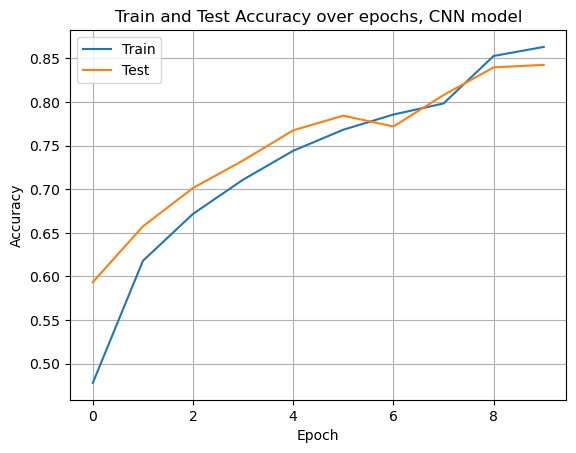

In [17]:
# plot train and test accuracies
plt.plot(range(train_epochs), train_accs, label='Train')
plt.plot(range(train_epochs), test_accs, label='Test')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over epochs, CNN model')
plt.grid()
plt.legend()
if CNN_model == simpleVGG:
    plt.savefig('simple_train_test_accuracy.png')
else:
    plt.savefig('vgg16_train_test_accuracy.png')
plt.show()

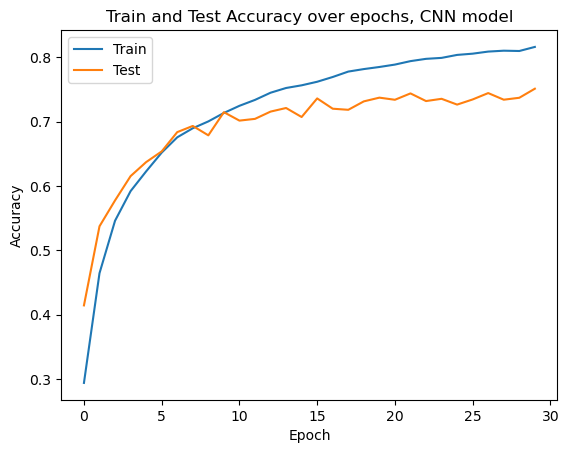
simpleVGG16

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### $\star$ Exercise 3: Optional exercises

These will *not* be asked as part of the exam, and are purely for your interest

#### **3.1. Say a network comes with a list of class probabilities:** $\hat{p}_1, \hat{p}_2, \dots \hat{p}_N$ **when is the cross-entropy in regards to the *true* class probabilities:** $p_1, p_2, \dots p_N$ **maximized?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

$\dots$

</span>

#### **3.2. When we sample from our dataloader, we sample in batches, why is this? What would be the alternatives to sampling in batches, and what impact would that have?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

$\dots$

</span>

#### **3.3. The "new kid on the block' (relatively speaking) in NLP (Natural Language processing), is self-attention. Basically this is letting each word/token relate to each other word/token by a specific 'attention' value, vaguely showing how much they relate to one another... Would there be any problems in doing this for image processing by simply letting each pixel relate to each other pixel, so we can get spatial information that way instead?**


<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

$\dots$

</span>

#### 💻 <input type="checkbox"> **3.3. Figure out, and implement the type, and exact settings of the optimizer the original VGG16-D implementation used**

**NOTE: The TAs tried this, and could not, for the life of us learn anything. Attempt this task at your peril!**


#### 💻 **3.4. A hint mentions, that if training with imagenette is taking too long, you can change the transforms of them to be smaller images, and that this *might* reduce accuracy. While making this exercise, a TA ran training with the original size of $224\times 224$ and thereafter downsized to $60\times 60$, both models were run for for one epoch. In the case of the downsized images, accuracy was $\approx 0.47$ as opposed to $\approx 0.28$ without downsizing. Try to replicate these results and explain why this might be the case.**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

$\dots$

</span>


#### **3.5. It's often a good idea to know the what and why of our data. Search the web for documentation on the "imagenette" dataset. Explain what it is, who made it, where it comes from, and what classes it contains. Why do you think it can exist in a world where imagenet exists?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

$\dots$

</span>


</span>





